<a href="https://colab.research.google.com/github/navyadeshmukh/vision-modelx/blob/main/ANNs/MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementation of Hand-written digit recognition model (Using MNIST dataset) using Pytorch Framework and Matplotlib.

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [ ]:
batch_size = 32
learning_rate = 0.05


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


Dataset Loading and preprocessing

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train, dev = random_split(train_dataset, [55000, 5000])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(dev, batch_size=batch_size)

Model Architecture : Two-layered Network
1 Layer : Batch Normalization, Dropout, 512 nodes
2 Layer : Softmax, 10 Nodes

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.Network = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(512,10)
    )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.Network(x)

Using Adam Optimizer and Cross Entropy Loss

In [ ]:
model = Network()

optimizer = torch.optim.AdamW(model.parameters(), lr= learning_rate, weight_decay = 1e-4)

loss= nn.CrossEntropyLoss()

Training And Validation workflow with Early stopping support

In [ ]:
epochs = 50

def accuracy(predictions, targets):
    _, predicted_labels = torch.max(predictions, 1)
    return (predicted_labels == targets).float().mean()


best_val_loss = float('inf')     # To track the lowest validation loss
patience = 5                     # Number of epochs to wait before stopping
patience_counter = 0            # How many epochs with no improvement
best_model_state = None         # Save the best model weights

train_acc = []
train_loss = []

for epoch in range(epochs):

    train_losses = list()
    train_accuracies = list()

    model.train()
    for batch in train_loader:

        x, y = batch
        x = x.view(-1, 28*28)
        predict = model(x)
        J = loss(predict, y)

        model.zero_grad()  #cleaning the gradient ,  param.grad = 0
        J.backward()
        optimizer.step()  # param = param - lr* param.grad

        train_losses.append(J.item())
        train_accuracies.append(accuracy(predict, y)) # Use accuracy function

    epoch_acc = torch.tensor(train_accuracies).mean()
    epoch_loss = torch.tensor(train_losses).mean()

    train_acc.append(epoch_acc.item())
    train_loss.append(epoch_loss.item())

    with torch.no_grad():

        val_losses = list()
        val_accuracies = list()
        model.eval()

        for batch in dev_loader:

            x, y = batch
            x = x.view(-1, 28*28)
            predict = model(x)
            J = loss(predict, y)


            val_losses.append(J.item())
            val_accuracies.append(accuracy(predict, y)) # Use accuracy function

        print(f'Epoch {epoch+1}, train_loss: {epoch_loss: .4f}, Train_acc: {epoch_acc * 100:.2f}% ; val_loss:{torch.tensor(val_losses).mean(): .4f}, val_accuracy: {torch.tensor(val_accuracies).mean() * 100:.2f}%')


    val_loss = torch.tensor(val_losses).mean()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()  # Save best model weights
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch 1, train_loss:  0.3726, Train_acc: 89.48% ; val_loss: 0.1887, val_accuracy: 94.55%
Epoch 2, train_loss:  0.2765, Train_acc: 92.06% ; val_loss: 0.1609, val_accuracy: 95.06%
Epoch 3, train_loss:  0.2482, Train_acc: 92.94% ; val_loss: 0.1115, val_accuracy: 96.38%
Epoch 4, train_loss:  0.2343, Train_acc: 93.37% ; val_loss: 0.1129, val_accuracy: 96.22%
Epoch 5, train_loss:  0.2298, Train_acc: 93.56% ; val_loss: 0.1258, val_accuracy: 95.94%
Epoch 6, train_loss:  0.2209, Train_acc: 93.65% ; val_loss: 0.0911, val_accuracy: 97.19%
Epoch 7, train_loss:  0.2197, Train_acc: 93.74% ; val_loss: 0.0927, val_accuracy: 96.82%
Epoch 8, train_loss:  0.2094, Train_acc: 94.13% ; val_loss: 0.1014, val_accuracy: 96.66%
Epoch 9, train_loss:  0.2068, Train_acc: 94.15% ; val_loss: 0.0809, val_accuracy: 97.21%
Epoch 10, train_loss:  0.2025, Train_acc: 94.28% ; val_loss: 0.1077, val_accuracy: 96.66%
Epoch 11, train_loss:  0.2017, Train_acc: 94.36% ; val_loss: 0.0761, val_accuracy: 97.51%
Epoch 12, train_los

/tmp/ipython-input-14-2254618381.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


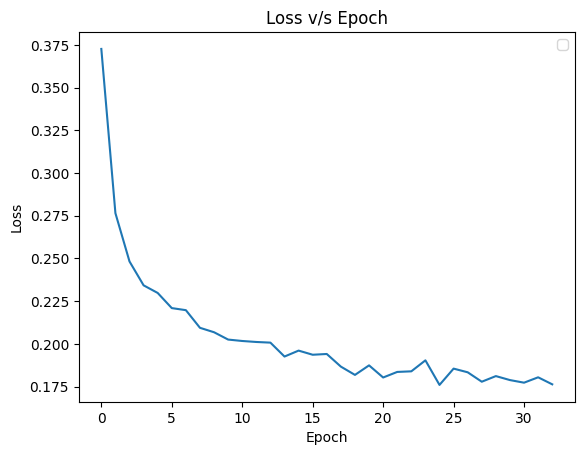

/tmp/ipython-input-14-2254618381.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


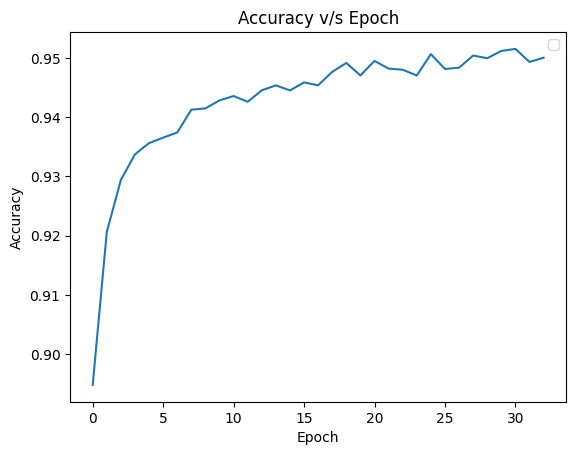

In [ ]:
# Plot Loss vs Epoch
num_epochs_completed = len(train_loss) # Get the actual number of completed epochs

plt.plot(range(num_epochs_completed), train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss v/s Epoch')
plt.legend()
plt.show()

# Plot Accuracy vs Epoch
plt.plot(range(num_epochs_completed), train_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy v/s Epoch')
plt.legend()
plt.show()


